### Exercise 1. MRFs and Images Denoising (40 points)

In this problem, you will implement the image de-noising example using a Markov Random Field (MRF).  This material on MRFs is covered in the textbook (Barber) in chapter 4.2.5. The lecture and this problem is based on the presentation in Bishop in chapter 8.3, which is available online.

As discussed in class, energy function for this MRF is

$$ E(\mathbf{x}, \mathbf{y}) = h \sum_i x_i - \beta \sum_{i,j} x_i x_j - \eta \sum_i x_i y_i $$

where the binary variables $x_i$ represent the unknown, noise-free image pixels, which are binary, i.e. black or white.  The variables $y_i$ represent the observed noisy pixels, i.e. the pixel could randomly change from black ($=-1$) to white ($=+1$) or vice-versa.  

The corresponding joint probability distribution over the variables is

$$ p(\mathbf{x},\mathbf{y}) = \frac{1}{Z} \exp \left[ -E(\mathbf{x},\mathbf{y}) \right] $$

## EECS 491 Assignment 3

Due Fri Mar 22 before midnight. 100 points total.

### Submitting assignments to Canvas

- For jupyter notebooks, submit the .ipynb file and a pdf or html export of the notebook.  Make sure the output represents the latest state of your notebook.  If you use interactive plots, make sure the output for the static file is representative of the points you wish to make.  If your are not using notebooks, writeup your assignment using latex and submit a pdf with your code.  The writeup should include relevant code with description if it can fit on a page.  Do not include binaries or large data files.

- Use the following format for filenames:
  - `EECS491-A3-yourcaseid.ipynb`
  - `EECS491-A3-yourcaseid.pdf`

- If you have more than these two files, put all your files in a directory named `EECS491-A3-yourcaseid`. Then zip the directory and submit it with the name `EECS491-A3-yourcaseid.zip`.  Do not use other compression formats.

1.1 (5 pts) Derive the equation that specifies the change in the energy equation when one variable changes state.

$$
\begin{align}
\mathbf{x} &= \mathop{\arg\,\max}_{\mathbf{x}}p(\mathbf{x},\mathbf{y}) \\
{log \rightarrow}&=  \mathop{\arg\,\max}_{\mathbf{x}}\,log\, p(\mathbf{x},\mathbf{y}) \\
{Z\, is\, constant \rightarrow} &= \mathop{\arg\,\max}_{\mathbf{x},\, x_i\, \in \{+1, -1\}} - \sum_i(h x_i - \beta \sum_{j} x_i x_j - \eta x_i y_i) \\
{assume\,other\,varaibleis\,constant \rightarrow x_i} &= \mathop{\arg\,\max}_{x_i \in \{+1,-1\}} (- h x_i + \beta \sum_{j} x_i x_j + \eta x_i y_i)  \\
{assign\, x_i \in \{+1,-1\}}&=  \mathop{\arg\,\max} \pm (-h+\beta\sum_jx_j+\eta y_i) \\
&=  \mathop{\arg\,\max} \pm (\beta\sum_jx_j+\eta y_i) \\ 
&= \mathop{sign}(\beta\sum_jx_j+\eta y_i)
\end{align}
$$

When $x_i$ and $x_j$, $y_i$ have the same sign, the energy will be loewer. When different. the energy will be higher.

1.2 (10 pts) Write a program to iteratively (or in random order) update the state variables to minimize the energy (maximize the probability).  Explain your code.  Show that the update algorithm minimizes the energy $E(\mathbf{x}, \mathbf{y})$.

In [4]:
import numpy as np
import matplotlib.pyplot as plt # plt show image
import matplotlib.image as pimg # read image
from PIL import Image

In [5]:
def denoise_image(Y, h, beta, eta):
    m, n = np.shape(Y)
    # initialize X same as Y
    X = np.copy(Y)
  
    # optimization 
    max_iter = 10*m*n
  
    for iter in range(max_iter):
        
        # randomly pick a pixel 
        i = np.random.randint(m)
        j = np.random.randint(n)

        # compute the log probabilities of both values of X_ij 
        log_p = compute_log_prob(X, Y, i, j, h, eta, beta)

        # assign X_ij to the value with higher log probability and lower energy
        X[i][j]=np.sign(log_p)
        
    return X

def compute_log_prob(X, Y, i, j, h, eta, beta):
    result = eta * Y[i][j] 
    result += beta  * compute_log_prob_helper(X, i-1, j)
    result += beta  * compute_log_prob_helper(X, i+1, j)
    result += beta  * compute_log_prob_helper(X, i, j-1)
    result += beta  * compute_log_prob_helper(X, i, j+1)
    result -= h
    return result

def compute_log_prob_helper(X, i, j):
    try:
        return X[i][j]
    except IndexError:
        return 0


def compute_energy_function(X, Y, h, beta, eta):
    m, n = np.shape(X)
    res = 0
    for i in range(m):
        for j in range(n):
            res += h * X[i][j] - compute_log_prob(X, Y, i, j, h, eta, beta)
    return res


1.3 (10 pts) Illustrate the model by plot of the image as it is being de-noised at the beginning, middle, and end of the updating.  Choose images that aren't too high resolution so that the individual pixels are visible as squaures.  You may also do a live plot in a notebook to show it updating continuously, but make sure you have the static plots too in case the dynamic plot has portability issues.

<IPython.core.display.Javascript object>


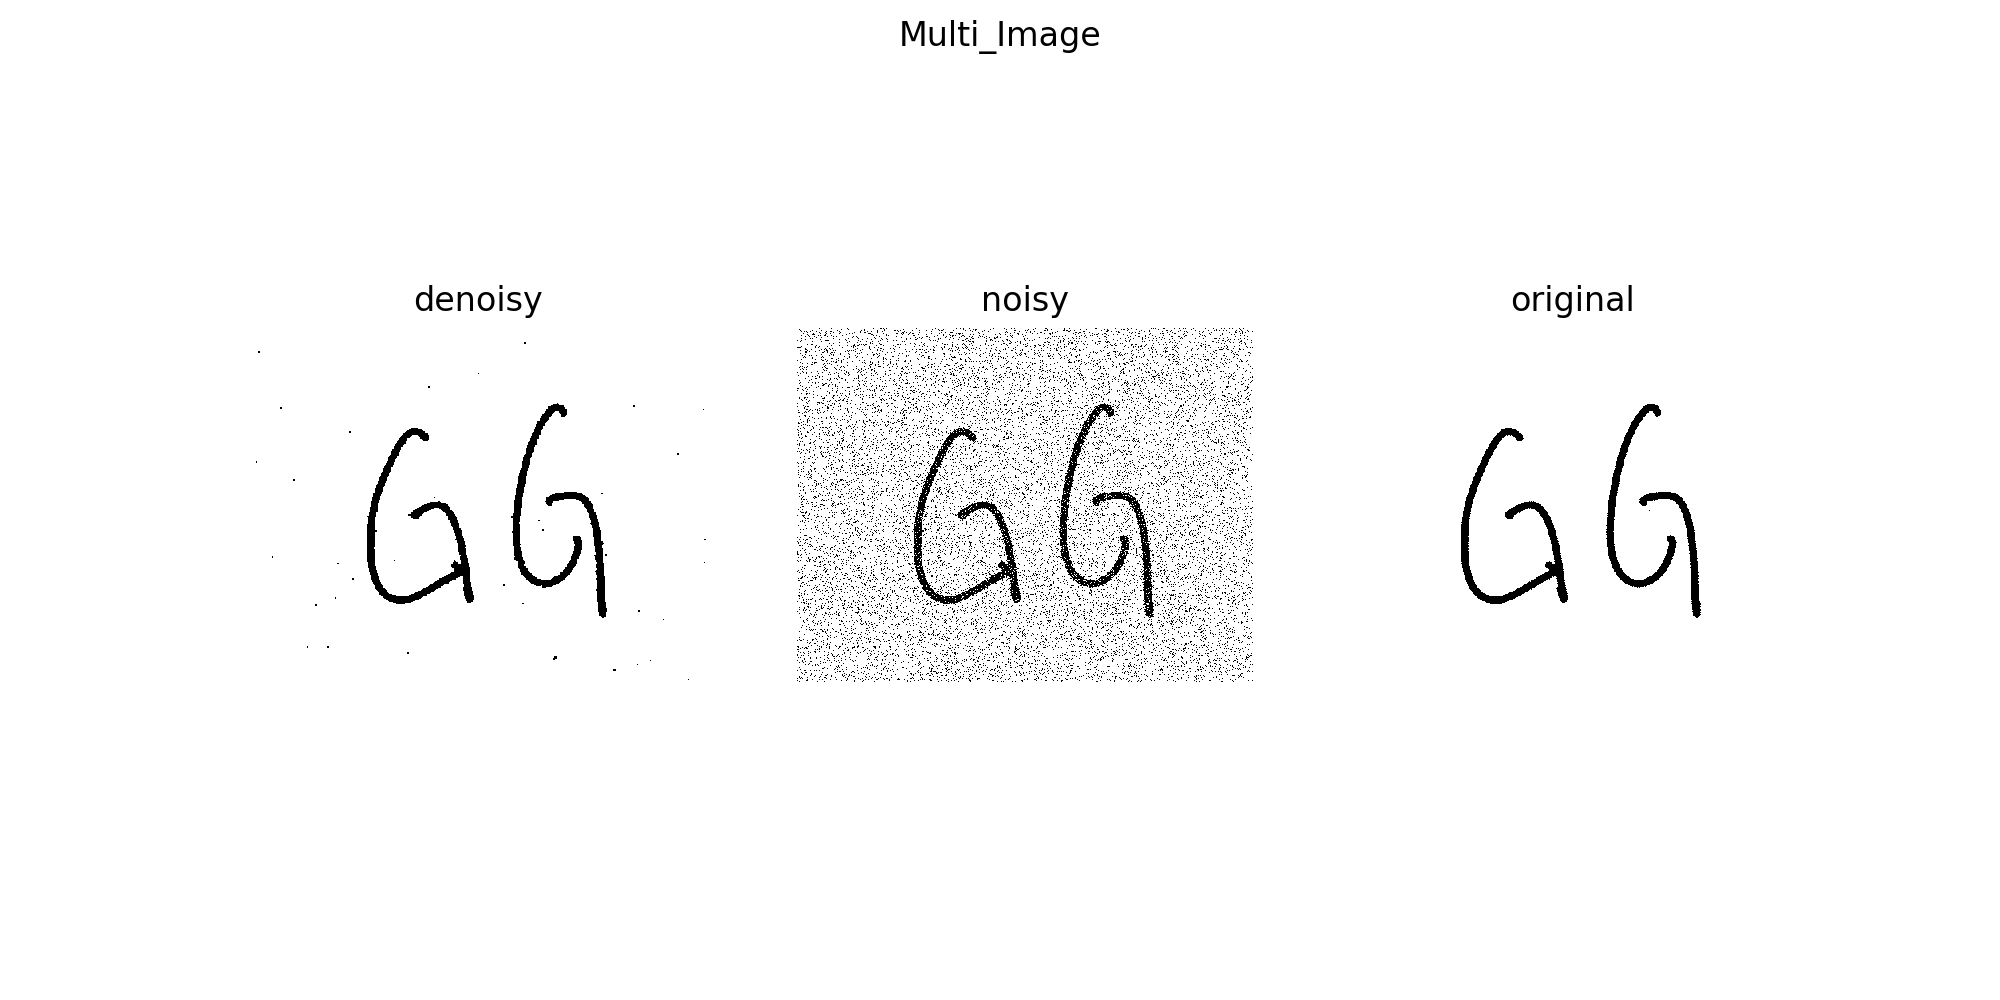

(-0.5, 570.5, 443.5, -0.5)

In [7]:
def add_noise(orig):
    A = np.copy(orig)
    
    for i in range(np.size(A, 0)):
        for j in range(np.size(A, 1)):
            r = np.random.rand()
            if r < 0.1:
                A[i][j] = -A[i][j]  
    return A


def read_image_and_binarize(image_file): 
    im = Image.open(image_file)
    L = im.convert('1')   #转化为二值化图
    # PIL convert pixel to [0,1], but we need [1, -1]
    A = np.asarray(L).astype(int)
    A[A == 0] = -1
    return A


# inital parameter
h = 5
beta = 10
eta = 10


# read img and binarize it
orig_image = read_image_and_binarize('test.jpeg')
noisy_image = add_noise(orig_image)
denoised_image = denoise_image(noisy_image, h, beta, eta)


%matplotlib notebook
plt.figure(figsize=(10,5))
plt.suptitle('Multi_Image') # 图片名称
plt.subplot(1,3,1), plt.title('denoisy')
plt.imshow(denoised_image, cmap='gray')
plt.axis('off')
plt.subplot(1,3,2), plt.title('noisy')        
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')
plt.subplot(1,3,3), plt.title('original')        
plt.imshow(orig_image, cmap='gray')
plt.axis('off')


1.4 (5 pts) Experiment with different settings of the energy equation parameters and explain your results.

<IPython.core.display.Javascript object>


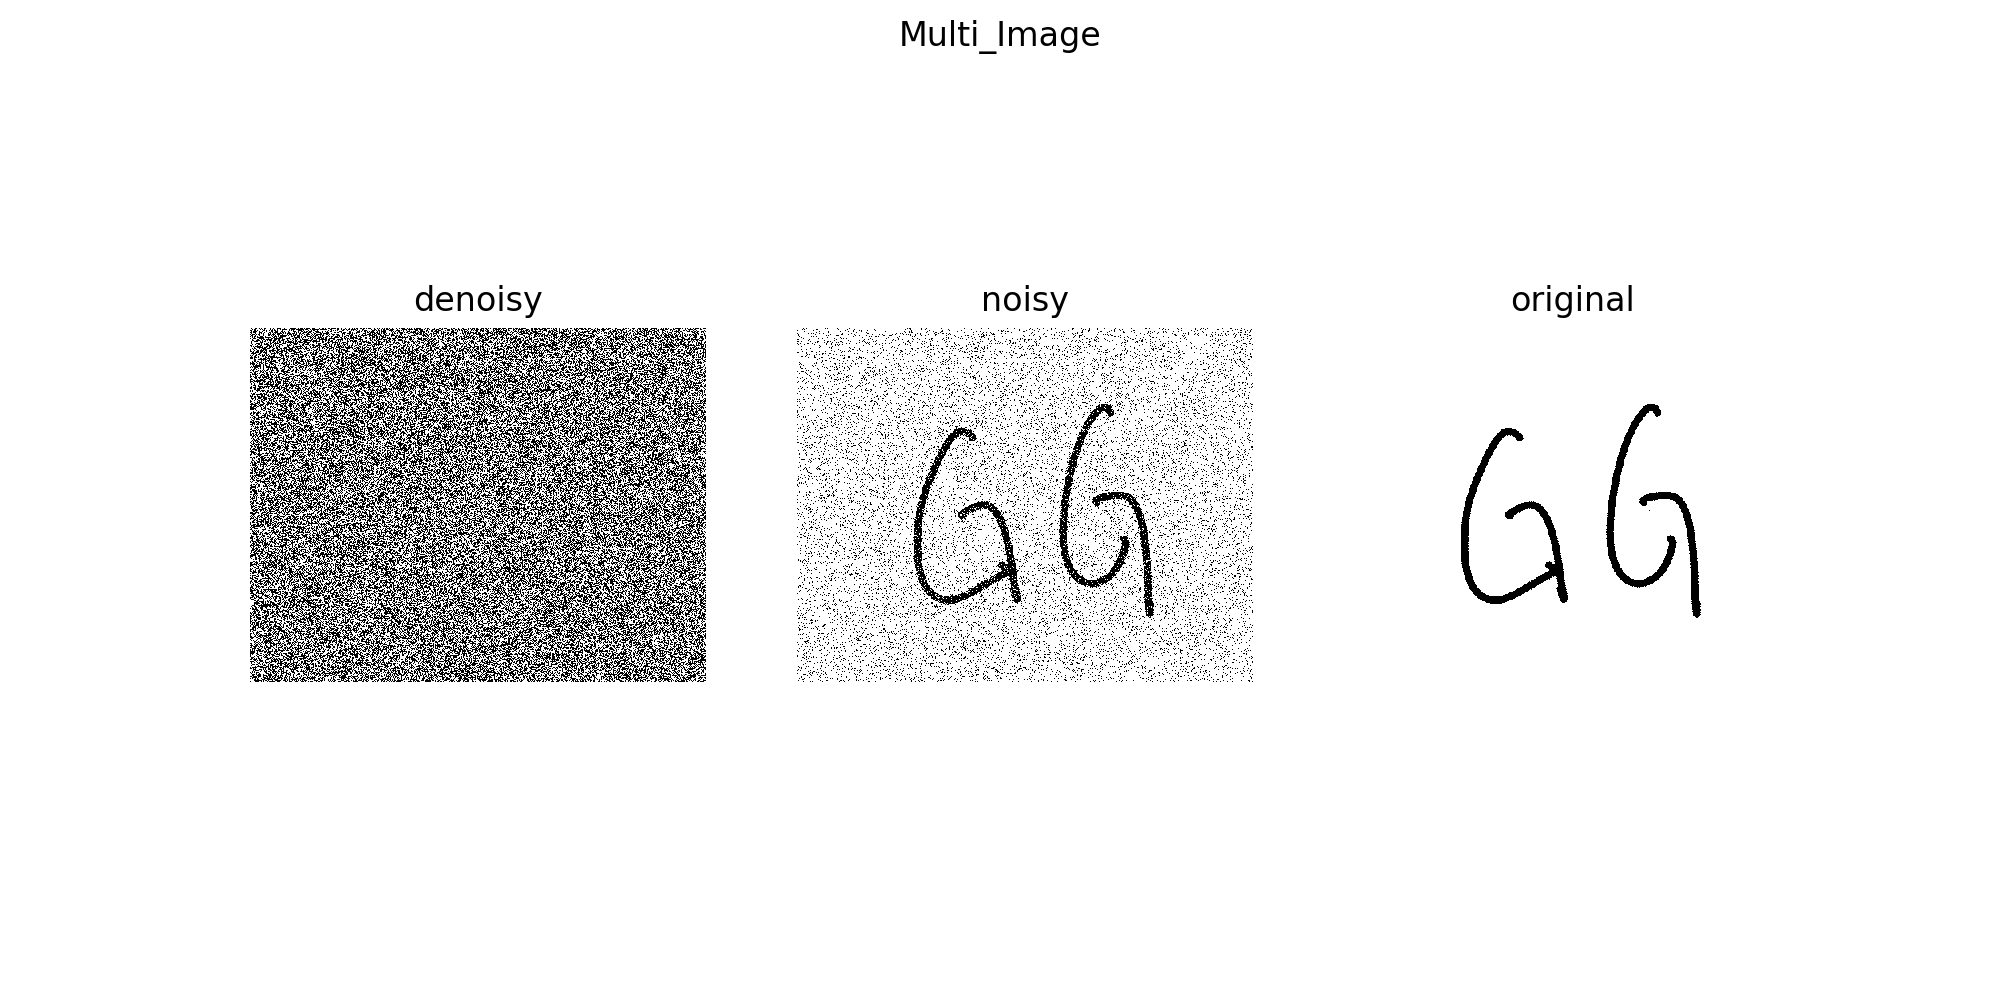

(-0.5, 570.5, 443.5, -0.5)

In [10]:
h = 100
beta = 10
eta = 10

# read img and binarize it
orig_image = read_image_and_binarize('test.jpeg')
noisy_image = add_noise(orig_image)
denoised_image = denoise_image(noisy_image, h, beta, eta)


%matplotlib notebook
plt.figure(figsize=(10,5))
plt.suptitle('Multi_Image') # 图片名称
plt.subplot(1,3,1), plt.title('denoisy')
plt.imshow(denoised_image, cmap='gray')
plt.axis('off')
plt.subplot(1,3,2), plt.title('noisy')        
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')
plt.subplot(1,3,3), plt.title('original')        
plt.imshow(orig_image, cmap='gray')
plt.axis('off')

Increase the value of h to 100. We get a very terrible result. 

<IPython.core.display.Javascript object>


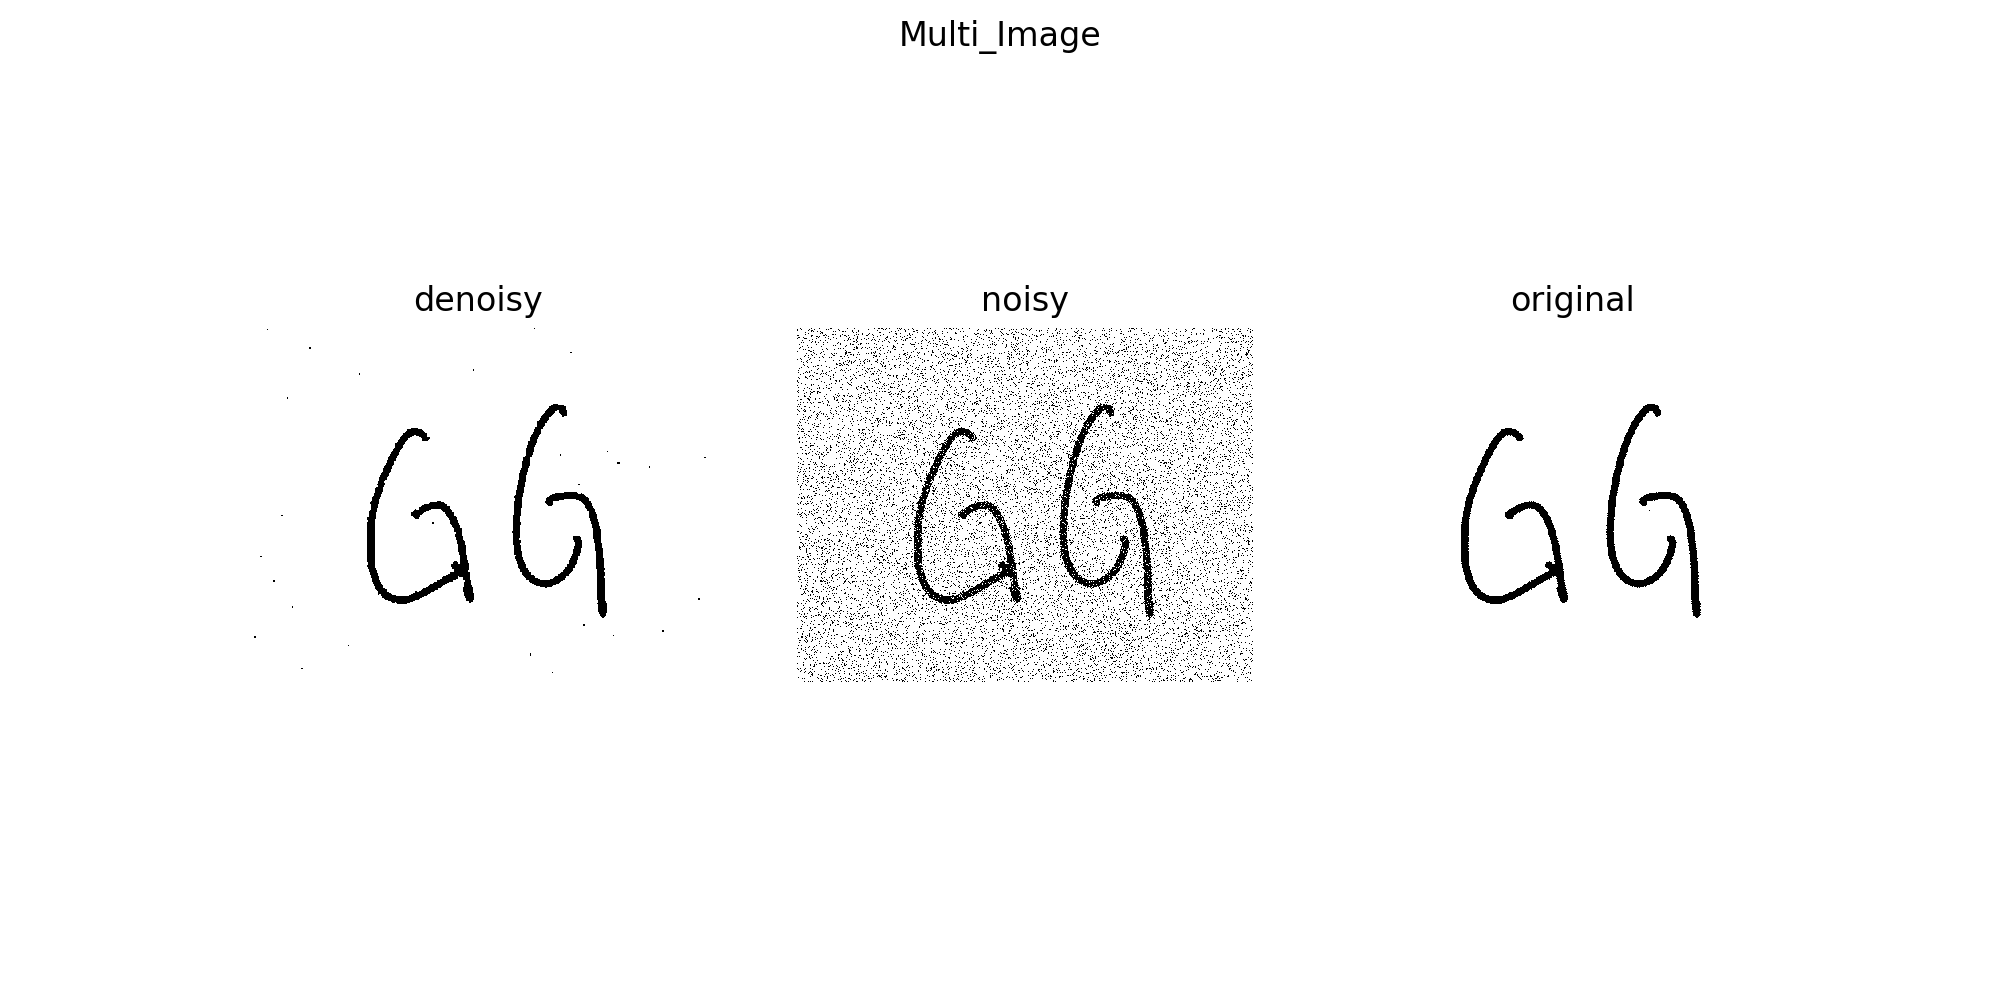

(-0.5, 570.5, 443.5, -0.5)

In [11]:
h = 5
beta = 100
eta = 10

# read img and binarize it
orig_image = read_image_and_binarize('test.jpeg')
noisy_image = add_noise(orig_image)
denoised_image = denoise_image(noisy_image, h, beta, eta)


%matplotlib notebook
plt.figure(figsize=(10,5))
plt.suptitle('Multi_Image') # 图片名称
plt.subplot(1,3,1), plt.title('denoisy')
plt.imshow(denoised_image, cmap='gray')
plt.axis('off')
plt.subplot(1,3,2), plt.title('noisy')        
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')
plt.subplot(1,3,3), plt.title('original')        
plt.imshow(orig_image, cmap='gray')
plt.axis('off')

Set $\beta$ to a very large value, we get a better result.

<IPython.core.display.Javascript object>


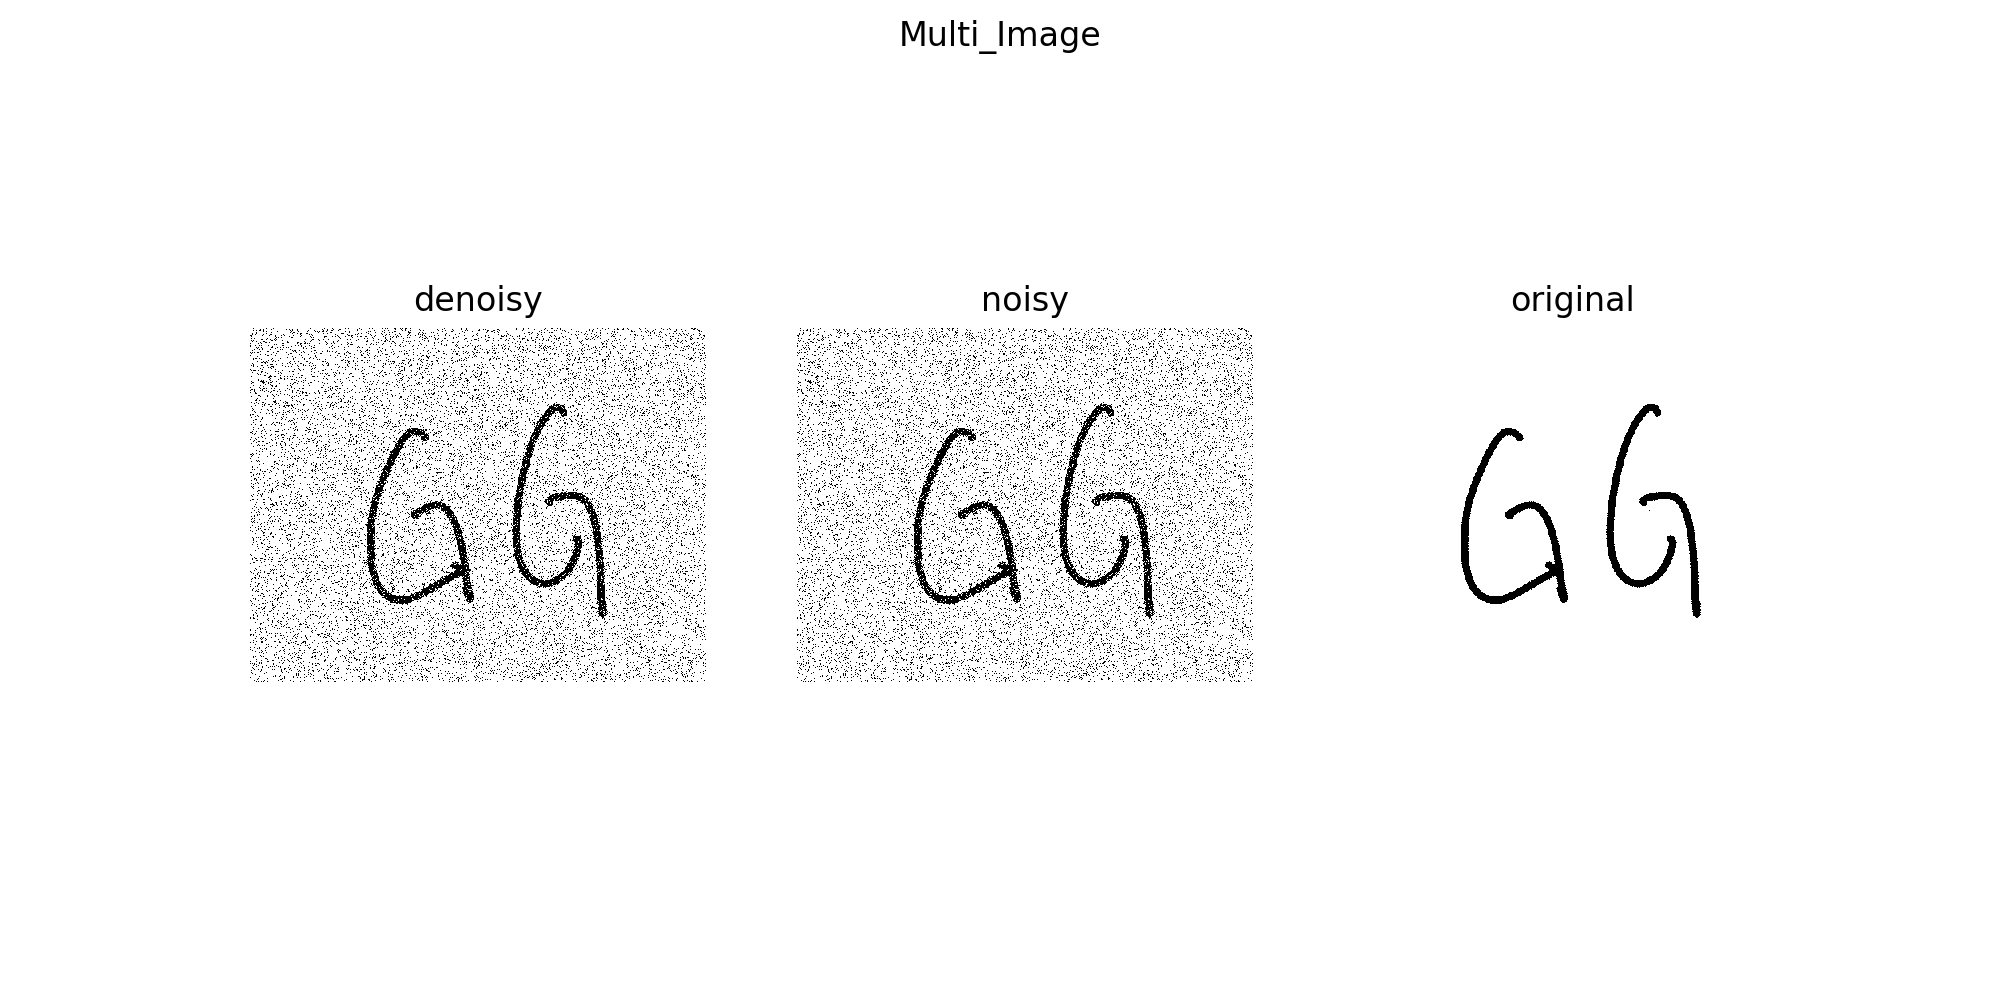

(-0.5, 570.5, 443.5, -0.5)

In [12]:
h = 5
beta = 10
eta = 100

# read img and binarize it
orig_image = read_image_and_binarize('test.jpeg')
noisy_image = add_noise(orig_image)
denoised_image = denoise_image(noisy_image, h, beta, eta)


%matplotlib notebook
plt.figure(figsize=(10,5))
plt.suptitle('Multi_Image') # 图片名称
plt.subplot(1,3,1), plt.title('denoisy')
plt.imshow(denoised_image, cmap='gray')
plt.axis('off')
plt.subplot(1,3,2), plt.title('noisy')        
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')
plt.subplot(1,3,3), plt.title('original')        
plt.imshow(orig_image, cmap='gray')
plt.axis('off')

Set $\eta$ to a large value, denoisy result is still teriible. The denoisied image is very similar to the noisy image. 


In a nut shell, we can increase the paramter $\beta$ to improve our performance.  

1.5 (10 pts)  Generalize the energy equation so that the model considers more that just pairs of pixels.  Explain your rationale behind this new model. Illustrate it with denoising examples (other types of images) with are not well-handled by the previous model.

We can change the energy equatio so that model will consider a clique, such as 3x3. The energy function is still look like: 
$ E(\mathbf{x}, \mathbf{y}) = h \sum_i x_i - \beta \sum_{i,j} x_i x_j - \eta \sum_i x_i y_i$. But the $x_j$ represent $x_i$'s neighboor. Now we not only consider the pixels on the top, left, right and bottom of $x

We can change the energy equatio so that model will consider a clique, such as 3x3. The energy function is still look like: 
$ E(\mathbf{x}, \mathbf{y}) = h \sum_i x_i - \beta \sum_{i,j} x_i x_j - \eta \sum_i x_i y_i$. But the $x_j$ represent $x_i$'s neighboor. Now we not only consider the pixels on the top, left, right and bottom of $x_i$, but we also consider the pixels on diagonal.

The previous model, the image will have some noise pixels remained in backgroudn after de-noise, in my new model the background have few noise pixel. 

<IPython.core.display.Javascript object>


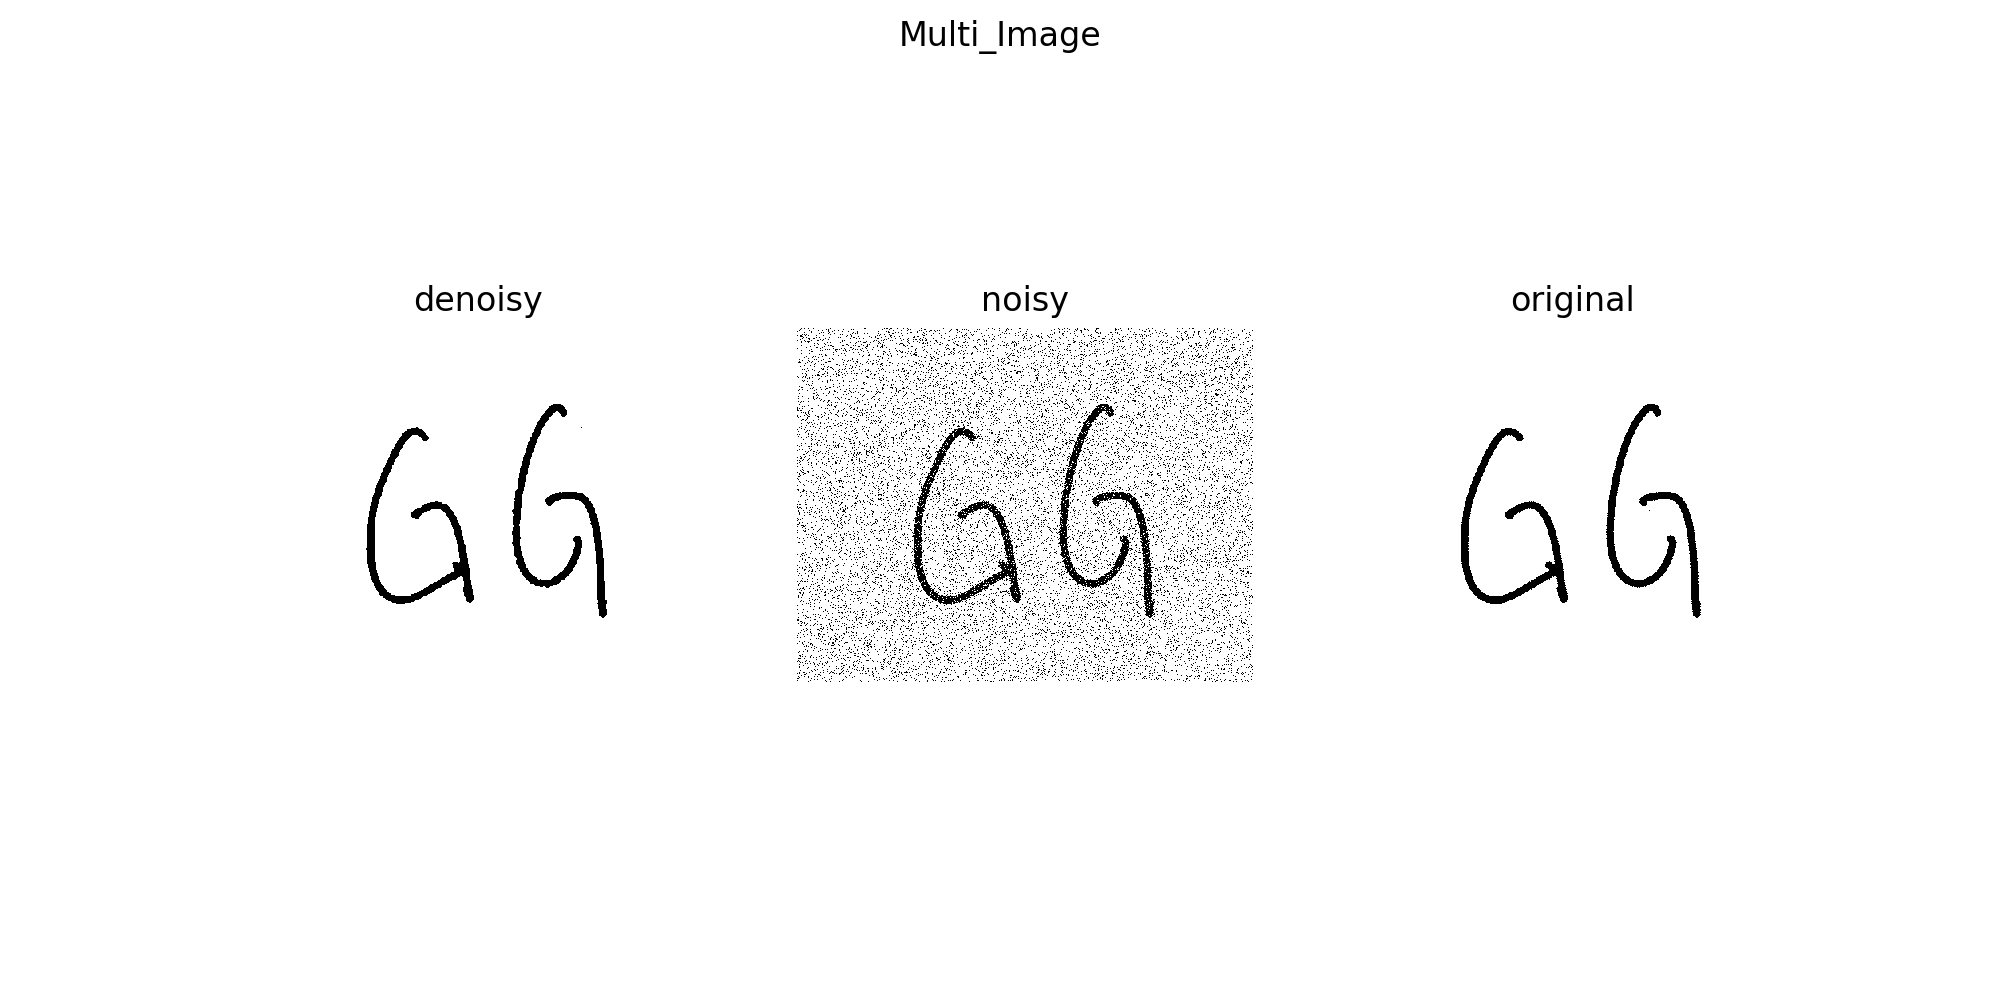

(-0.5, 570.5, 443.5, -0.5)

In [15]:
def denoise_image(Y, h, beta, eta):
    m, n = np.shape(Y)
    # initialize X same as Y
    X = np.copy(Y)
  
    # optimization 
    max_iter = 10*m*n
  
    for iter in range(max_iter):
        
        # randomly pick a pixel 
        i = np.random.randint(m)
        j = np.random.randint(n)

        # compute the log probabilities of both values of X_ij 
        log_p = compute_log_prob(X, Y, i, j, h, eta, beta)

        # assign X_ij to the value with higher log probability and lower energy
        X[i][j]=np.sign(log_p)
        
    return X

def compute_log_prob(X, Y, i, j, h, eta, beta):
    result = eta * Y[i][j] 
    result += beta  * compute_log_prob_helper(X, i-1, j)
    result += beta  * compute_log_prob_helper(X, i+1, j)
    result += beta  * compute_log_prob_helper(X, i, j-1)
    result += beta  * compute_log_prob_helper(X, i, j+1)
    result += beta  * compute_log_prob_helper(X, i+1, j+1)
    result += beta  * compute_log_prob_helper(X, i+1, j-1)
    result += beta  * compute_log_prob_helper(X, i-1, j+1)
    result += beta  * compute_log_prob_helper(X, i-1, j-1)

    result -= h
    return result

def compute_log_prob_helper(X, i, j):
    try:
        return X[i][j]
    except IndexError:
        return 0


def compute_energy_function(X, Y, h, beta, eta):
    m, n = np.shape(X)
    res = 0
    for i in range(m):
        for j in range(n):
            res += h * X[i][j] - compute_log_prob(X, Y, i, j, h, eta, beta)
    return res

h = 5
beta = 10
eta = 10

# read img and binarize it
orig_image = read_image_and_binarize('test.jpeg')
noisy_image = add_noise(orig_image)
denoised_image = denoise_image(noisy_image, h, beta, eta)


%matplotlib notebook
plt.figure(figsize=(10,5))
plt.suptitle('Multi_Image') # 图片名称
plt.subplot(1,3,1), plt.title('denoisy')
plt.imshow(denoised_image, cmap='gray')
plt.axis('off')
plt.subplot(1,3,2), plt.title('noisy')        
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')
plt.subplot(1,3,3), plt.title('original')        
plt.imshow(orig_image, cmap='gray')
plt.axis('off')

### Exercise 2. Graphical Representation (15 points)

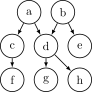

In [1]:
using TikzPictures

# manual layout: straightforward, predictable
g = TikzPicture(L""" % latex/TikZ code
% define styles
\tikzstyle{every node} = [draw, circle, minimum size=7mm]
\tikzset{>=latex}
% add nodes
\foreach \n/\x/\y in {a/1.5/3, b/2.5/3, c/1/2, d/2/2, e/3/2, f/1/1, g/2/1, h/3/1}
    \node (\n) at (\x,\y) {\n};
% draw links
\foreach \from/\to in {a/c, a/d, b/d, b/e, c/f, d/g, d/h}
    \draw [->] (\from) -- (\to);
""", options="thick, scale=1.2, transform shape")

2.1 (5 pts) For the Bayesian network show above, draw the corresponding Markov Random Field (MRF), and write out the joint probability using potential functions.  You do not need to specify the functions themselves, only which arguments they take.

In [1]:
# import package
from graphviz import Graph
from graphviz import Digraph

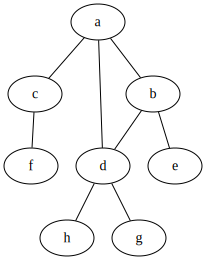

In [17]:
G = Graph()

G.edge('a', 'c')
G.edge('c', 'f')
G.edge('a', 'd')
G.edge('d', 'h')
G.edge('d', 'g')
G.edge('a', 'b')
G.edge('b', 'e')
G.edge('b', 'd')

G

$$
p(a,b,c,d,e,f,g,h) = \frac{1}{Z}\psi(a,b,d)\psi(a,c)\psi(c,f)\psi(b,e)\psi(d,g)\psi(d,h)
$$

2.2 (5 pts) Now specify the Bayes net as a factor graph.  Again write the expression for the joint probability, but using factor functions.

$$
p(a,b,c,d,e,f,g,h) = f(a,b,d)f(c,f)f(a,c)f(b,e)f(d,h)f(d,g)
$$

2.3 (5 pts) Express the following Bayes net (from the sprinkler example) in two different factor graphs.  For each network, write the factors as a function of the conditional probabilties and specify the joint probability.

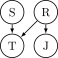

In [2]:
# automatic layout: usually more concise and compact but not always predictable
g = TikzPicture(L"""
\graph [simple, grow down, branch right, edges={>=latex},
        nodes={draw, circle, minimum size=7mm} ] {
    {S,R} -> {T,J}, R -> T
};
""", options="thick, scale=1.2, transform shape", 
    preamble="\\usetikzlibrary{graphs}")

$$
p(S,R,J,T) = f_1(S,R,T)f_2(R,J)
$$

$f_1(S,R,T) = p(T|S,R)p(S)p(R)\,, f_2(R,J) = p(J|R)$, The joint probability is $p(S,R,J,T) = p(S)p(R)p(J|R)p(T|S,R)$

$$
p(S,R,J,T) = f_1(S)f_2(R)f_3(R,J)f_4(S,R,T)
$$

$f_1(S)=p(S),f_2(R)=p(R),f_3(R,J)=p(J|R),f_4(S,R,T)= p(T|S,R)$, The joint probability is $p(S,R,J,T) = p(S)p(R)p(J|R)p(T|S,R)$ 

### Exercise 3. The Sum Product Algorithm (25 pts)

Consider the following factor graph.

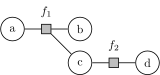

In [3]:
g = TikzPicture(L"""
% define node styles
\tikzstyle{every node}  = [draw, circle, minimum size=7mm]
\tikzstyle{every label} = [draw=none, inner sep=0pt]
\tikzstyle{factor}      = [draw, rectangle, scale=0.4, fill=black!25]

% (Aside: Why can we add blank lines here, but not in the first graph??)
% variable nodes
\foreach \v/\x/\y in {a/1/2, b/3/2, c/3/1, d/5/1}
    \node (\v) at (\x,\y) {\v};

% factor nodes
\foreach \n/\x/\y/\pos in {1/2/2/above, 2/4/1/above}
    \node [factor, label=\pos:$f_\n$] (f\n) at (\x,\y) {};

% edges
\foreach \from/\to in {a/f1, f1/b, f1/c, c/f2, f2/d}
    \draw (\from) -- (\to);
""", options="thick, scale=1.2, transform shape")

3.1 (10 pts) Apply the sum-product algorithm to compute the all messages when none of the variables are known.

First set of message:
$$
\mu_{a \rightarrow f_1}(a) = 1 \\
\mu_{b \rightarrow f_1}(b) = 1 \\ 
\mu_{f_1 \rightarrow c}(c) = \sum_{a}\sum_{b}f_1(a,b,c) \\
\mu_{c \rightarrow f_2}(c) = \mu_{f_1 \rightarrow c}(c) \\
\mu_{f_2 \rightarrow d}(d) = \sum_{c}f_2(c,d)\mu_{c \rightarrow f_2}(c) \\
$$

Second set of message:
$$
\mu_{d \rightarrow f_2}(d) = 1 \\
\mu_{f_2 \rightarrow c}(c) = \sum_df_2(c,d)\\
\mu_{c \rightarrow f_1}(c) =  \mu_{f_2 \rightarrow c}(c)\\
\mu_{f_1 \rightarrow a}(a) = \sum_b\sum_cf_1(a,b,c)\mu_{c \rightarrow f_1}(c)\mu_{b \rightarrow f_1}(b) \\
\mu_{f_1 \rightarrow b}(b) = \sum_a\sum_cf_1(a,b,c)\mu_{c \rightarrow f_1}(c)\mu_{a \rightarrow f_1}(a)
$$

3.2 (5 pts) Compute the marginal probability  p(c) , expressing it in terms of the messages you derived in the previous question.

$$
p(c) = \mu_{f_2 \rightarrow c}(c)\mu_{f_1 \rightarrow c}(c)
$$

3.3 (5 pts) Verify that the marginal is the correct expression substituting in the message definitions.

We have known that the $$p(\mathbf{x}) = f_1(a,b,c)f_2(c,d)$$

Thus, 
$$
\begin{align}
p(c) &= \mu_{f_2 \rightarrow c}(c)\mu_{f_1 \rightarrow c}(c)\\
&= [\sum_df_2(c,d)][ \sum_a\sum_b f_1(a,b,c)] \\
&= \sum_a\sum_b\sum_df_2(c,d)f_1(a,b,c) \\
&= \sum_a\sum_b\sum_dp(\mathbf{x})
\end{align}
$$

Now consider adding a loop to the graph.

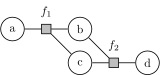

In [4]:
g = TikzPicture(L"""
% define node styles
\tikzstyle{every node}  = [draw, circle, minimum size=7mm]
\tikzstyle{every label} = [draw=none, inner sep=0pt]
\tikzstyle{factor}      = [draw, rectangle, scale=0.4, fill=black!25]

% (Aside: Why can we add spaces here, but not above??)
% variable nodes
\foreach \v/\x/\y in {a/1/2, b/3/2, c/3/1, d/5/1}
    \node (\v) at (\x,\y) {\v};

% factor nodes
\foreach \n/\x/\y/\pos in {1/2/2/above, 2/4/1/above}
    \node [factor, label=\pos:$f_\n$] (f\n) at (\x,\y) {};

% edges
\foreach \from/\to in {a/f1, f1/b, b/f2, f1/c, c/f2, f2/d}
    \draw (\from) -- (\to);
""", options="thick, scale=1.2, transform shape")

3.4 (5 pts) Explore the consequences of applying the sum-product algorithm to this graph. Can the algorithm still be applied?

The algorithm can't be applied to the graph. They will have a loop. 
Consider that $\mu_{f_2 \rightarrow c}(c) = \sum_a\sum_bf_2(a,b,c)\mu_{b \rightarrow f_2}(b)\mu_{d \rightarrow f_2}(c)$  

$\mu_{b \rightarrow f_2}(b) = \sum_a\sum_cf_1(a,b,c)\mu_{c \rightarrow f_1}(c) \mu_{a \rightarrow f_1}(a)$

$\mu_{c \rightarrow f_1}(c) = \mu_{f_2 \rightarrow c}(c) = \sum_a\sum_bf_2(a,b,c)\mu_{b \rightarrow f_2}(b)\mu_{d \rightarrow f_2}(c) = \sum_a\sum_bf_2(a,b,c)\mu_{d \rightarrow f_2}(c)\sum_a\sum_cf_1(a,b,c)\mu_{c \rightarrow f_1}(c) \mu_{a \rightarrow f_1}(a)$ 

The last euqation has two $\mu_{c \rightarrow f_1}(c)$ , thus it cannot be applied.

### Exploration (20 points)

Select a topic from the readings (Barber chapters 4 and 5, Murphy chapters 19 and 20, or Bishop Chapter 8) and write your own exercise.  It should aim to teach or explore a concept you don't understand or found interesting.  Like before, you don't do an excessive amount of work.  This isn't a project.  Aim for something worth about 20 points, i.e. about half as much work has exercise 1 or a little more work than exercise 2.

Grading rubric:
- Clarity of explanation. Could another student read and do this? (5 pts)
- Novelty or distinctness. Does it complement or go beyond what was covered above? (5 pts)
- Does the exercise teach something about the concept(s)? (5 pts)
- How deeply does it explore the concept(s)? (5 pts)

Consider the following Chain Graphical Model.

In [37]:
from graphviz import Source

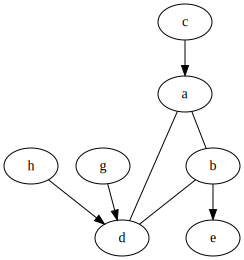

In [67]:
G = Digraph()

G.edge('a', 'b', dir='none')
G.edge('a', 'd',dir='none')
G.edge('b', 'd', dir='none')

G.edge('c','a')
G.edge('h','d')
G.edge( 'g','d')
G.edge('b', 'e')

G

Calculate it joint probability.

$p(a,b,c,d,e,f,g,h) = p(c)p(h)p(g)p(a,b,d|c,h,g)p(e|a,b,d)$

Calculate the marginal $p(a,b,d)$

$p(a,b,d|c,h,g) = p(d|h)p(g|d)p(a|c)\phi(a,d)\phi(a,b)\phi(b,d)\phi(h,g)\phi(h,c)\phi(g,c)$  
$p(a,b,d) = \phi(a,d)\phi(a,b)\phi(b,d)\sum_{c,g,h}p(d|h)p(g|d)p(a|c)\phi(h,g)\phi(h,c)\phi(g,c)$

Calculate the margianl p(e)

$p(e) = \sum_a\sum_b\sum_dp(e|a,b,d)p(a,b,d)$